In [1]:
pwd

'/Users/flatironstudentaccount/Documents/course-material/Projects/Project03/Project03_v2/Project03'

In [ ]:
jupyter nbconvert /Users/flatironstudentaccount/Documents/course-material/Projects/Project03/Project03_v2/Project03/Mod3_Final.ipynb --to slides --post serve --SlidesExporter.reveal_theme=serif --SlidesExporter.reveal_scroll=True --SlidesExporter.reveal_transition=none 

In [2]:
#helpful schema that Alan created to show connections between different dbs: 
#https://dbdiagram.io/d/5ceeb0811f6a891a6a658200

In [3]:
#https://machinelearningmastery.com/how-to-code-the-students-t-test-from-scratch-in-python/
#https://www.sagepub.com/sites/default/files/upm-binaries/33663_Chapter4.pdf
#consulted these resources for help with statistical analysis

#https://www.kaggle.com/efezinoerome/analyzing-soccer-data
#http://www.statstutor.ac.uk/resources/uploaded/tutorsquickguidetostatistics.pdf
#also consulted

#https://math.stackexchange.com/questions/2173385/semantics-binomial-vs-binary

# https://towardsdatascience.com/hypothesis-testing-in-the-northwind-dataset-using-anova-db3ab16b5eba

# https://www.quora.com/What-does-a-high-F-value-usually-mean-and-why

### Load in necessary libraries

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from numpy.random import seed
from numpy.random import randn
from scipy.stats import sem
from scipy.stats import t
from math import sqrt
from scipy.stats import chi2_contingency
from scipy.stats import chi2
import pandas as pd
import random

### Create functions to load database

In [5]:
def connect_to_sql_database(database_file_name):
    import sqlite3
    connection = sqlite3.connect(database_file_name)
    cursor = connection.cursor()
    return connection, cursor

In [6]:
conn, c = connect_to_sql_database('database1.sqlite')

In [7]:
def sql_query_to_df(cursor, sql_query):
    import pandas as pd
    c.execute(sql_query)
    df = pd.DataFrame(c.fetchall())
    df.columns = [x[0] for x in c.description]
    return df

In [8]:
def get_all_tables_from_sql_database(cursor):
    df = sql_query_to_df(c, """SELECT 
                                    name
                                FROM 
                                    sqlite_master 
                                WHERE 
                                    type ='table' AND 
                                    name NOT LIKE 'sqlite_%';""")
    return df

In [9]:
get_all_tables_from_sql_database(c)

,name
0,Player_Attributes
1,Player
2,Match
3,League
4,Country
5,Team
6,Team_Attributes


In [10]:
#Load up information from Match and Player_Attributes Databases
df = sql_query_to_df(c, """SELECT * FROM Match""")
print(df.head())
df1 = sql_query_to_df(c, """SELECT * FROM Player_Attributes""")
df1.head()

   id  country_id  league_id     season  stage                 date  \
0   1           1          1  2008/2009      1  2008-08-17 00:00:00   
1   2           1          1  2008/2009      1  2008-08-16 00:00:00   
2   3           1          1  2008/2009      1  2008-08-16 00:00:00   
3   4           1          1  2008/2009      1  2008-08-17 00:00:00   
4   5           1          1  2008/2009      1  2008-08-16 00:00:00   

   match_api_id  home_team_api_id  away_team_api_id  home_team_goal  ...  \
0        492473              9987              9993               1  ...   
1        492474             10000              9994               0  ...   
2        492475              9984              8635               0  ...   
3        492476              9991              9998               5  ...   
4        492477              7947              9985               1  ...   

    SJA   VCH   VCD   VCA   GBH   GBD   GBA   BSH   BSD   BSA  
0  4.00  1.65  3.40  4.50  1.78  3.25  4.00  1.73  3

,id,player_fifa_api_id,player_api_id,date,overall_rating,potential,preferred_foot,attacking_work_rate,defensive_work_rate,crossing,...,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
0,1,218353,505942,2016-02-18 00:00:00,67.0,71.0,right,medium,medium,49.0,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
1,2,218353,505942,2015-11-19 00:00:00,67.0,71.0,right,medium,medium,49.0,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
2,3,218353,505942,2015-09-21 00:00:00,62.0,66.0,right,medium,medium,49.0,...,54.0,48.0,65.0,66.0,69.0,6.0,11.0,10.0,8.0,8.0
3,4,218353,505942,2015-03-20 00:00:00,61.0,65.0,right,medium,medium,48.0,...,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0
4,5,218353,505942,2007-02-22 00:00:00,61.0,65.0,right,medium,medium,48.0,...,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0


In [11]:
df1b=df1.copy()

In [12]:
#Check columns in each Database to be analyzed 
print(df.columns)
df1.columns

Index(['id', 'country_id', 'league_id', 'season', 'stage', 'date',
       'match_api_id', 'home_team_api_id', 'away_team_api_id',
       'home_team_goal',
       ...
       'SJA', 'VCH', 'VCD', 'VCA', 'GBH', 'GBD', 'GBA', 'BSH', 'BSD', 'BSA'],
      dtype='object', length=115)


Index(['id', 'player_fifa_api_id', 'player_api_id', 'date', 'overall_rating',
       'potential', 'preferred_foot', 'attacking_work_rate',
       'defensive_work_rate', 'crossing', 'finishing', 'heading_accuracy',
       'short_passing', 'volleys', 'dribbling', 'curve', 'free_kick_accuracy',
       'long_passing', 'ball_control', 'acceleration', 'sprint_speed',
       'agility', 'reactions', 'balance', 'shot_power', 'jumping', 'stamina',
       'strength', 'long_shots', 'aggression', 'interceptions', 'positioning',
       'vision', 'penalties', 'marking', 'standing_tackle', 'sliding_tackle',
       'gk_diving', 'gk_handling', 'gk_kicking', 'gk_positioning',
       'gk_reflexes'],
      dtype='object')

In [13]:
#Set up columns to see who won or lost or draw
df['HomeWin']=df.home_team_goal>df.away_team_goal
df['AwayWin']=df.away_team_goal>df.home_team_goal
df['Draw']=df.home_team_goal==df.away_team_goal

In [14]:
#Percentage of wins at home (across the dataset)
df.HomeWin.sum()/df.HomeWin.shape[0]

0.45871665576042187

In [15]:
#Percentage of wins across the dataset when away
df.AwayWin.sum()/df.AwayWin.shape[0]
#The effect size of playing home/away appears to be substantial, 
#this will be confirmed with statistical testing

0.28738596558759

### Need to answer this question: Is there a statistical difference in the odds of winning a game when a team is playing in front of their home crowd?

In [16]:
def homewinbinary(df):
    win_dict={}
    #for home wins
    games_home = df.groupby(df.home_team_api_id) #slice by home id
    games_away = df.groupby(df.away_team_api_id) #slice by away id
    team_ids = list(games_home.groups.keys()) #get individual team ids
    #calculate and store home win percentages
    for team in team_ids:
        x=games_home.get_group(team) #grab home wins
        y=games_away.get_group(team) #grab everything else
        
        home_per=x.HomeWin.sum()/len(x.HomeWin) #calculate Home win percentage
        else_per=(1 - home_per) #calculate complement of Home win percentage
        
        win_dict[team]=[home_per,else_per] #store

        
        
    win_df=pd.DataFrame(win_dict).T
    return win_df
binary = homewinbinary(df)
binary.head()

,0,1
1601,0.450000,0.550000
1773,0.355556,0.644444
1957,0.525000,0.475000
2033,0.253333,0.746667
2182,0.616667,0.383333


In [17]:
wins = df[['HomeWin', 'AwayWin', 'Draw']]

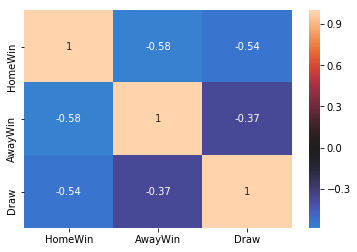

In [18]:
sns.heatmap(wins.corr(), annot=True, center=0);

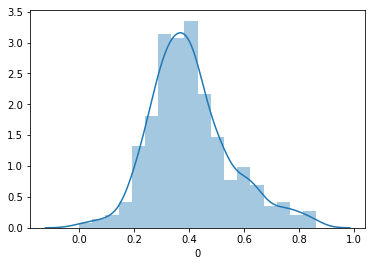

In [19]:
#Histogram of all games that are not a home win
sns.distplot(binary[0])

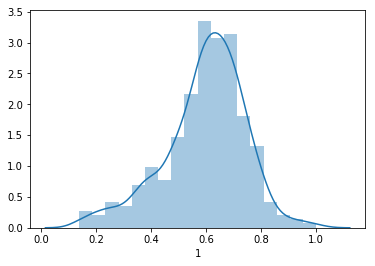

In [20]:
#Histogram of games that were home wins
sns.distplot(binary[1])

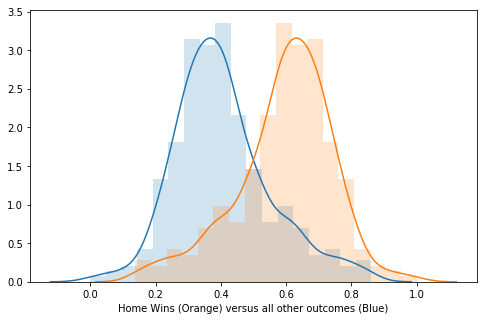

In [21]:
# Plotting the distributions for the 5 goalie metrics before log-transformation
plt.figure(figsize=(8,5))
for skill in binary.columns:
    sns.distplot((binary[skill]), hist_kws=dict(alpha=0.2))
    plt.xlabel('Home Wins (Orange) versus all other outcomes (Blue)')

In [22]:
x = binary[0]
y = binary[1]
ttest=stats.ttest_ind(x,y)
print('T-test independent, one tailed p-value: ', ttest[1])

T-test independent, one tailed p-value:  7.977152115768083e-48


In [23]:
print('T-test independent, two tailed p-value: ', ttest[1]*2)

T-test independent, two tailed p-value:  1.5954304231536166e-47


In [24]:
ttest=stats.ttest_rel(x,y)
ttest

Ttest_relResult(statistic=-11.2591847895789, pvalue=9.70767116964689e-25)

In [25]:
stats.mannwhitneyu(x,y)

MannwhitneyuResult(statistic=15739.5, pvalue=4.452380650142112e-43)

In [26]:
#Strong t-stat evidence
visualize_t(-11.2591847895789, n_cont, n_exp)

NameError: name 'visualize_t' is not defined

In [ ]:
def evaluate_PDF(rv, x=4):
    '''Input: a random variable object, standard deviation
       output : x and y values for the normal distribution
       '''
    
    # Identify the mean and standard deviation of random variable 
    mean = rv.mean()
    std = rv.std()

    # Use numpy to calculate evenly spaced numbers over the specified interval (4 sd) and generate 100 samples.
    xs = np.linspace(mean - x*std, mean + x*std, 100)
    
    # Calculate the peak of normal distribution i.e. probability density. 
    ys = rv.pdf(xs)

    return xs, ys # Return calculated values

In [ ]:
def Cohen_d(group1, group2):

    # Compute Cohen's d.

    # group1: Series or NumPy array
    # group2: Series or NumPy array

    # returns a floating point number 

    diff = group1.mean() - group2.mean()

    n1, n2 = len(group1), len(group2)
    var1 = group1.var()
    var2 = group2.var()

    # Calculate the pooled threshold as shown earlier
    pooled_var = (n1 * var1 + n2 * var2) / (n1 + n2)
    
    # Calculate Cohen's d statistic
    d = diff / np.sqrt(pooled_var)
    
    return d
Cohen_d(y, x)

In [ ]:
def overlap_superiority(group1, group2, n=299):
    """Estimates overlap and superiority based on a sample.
    
    group1: scipy.stats rv object
    group2: scipy.stats rv object
    n: sample size
    """

    # Get a sample of size n from both groups
    group1_sample = group1.rvs(n)
    group2_sample = group2.rvs(n)
    
    # Identify the threshold between samples
    thresh = (group1.mean() + group2.mean()) / 2
    print(thresh)
    
    # Calculate no. of values above and below for group 1 and group 2 respectively
    above = sum(group1_sample < thresh)
    below = sum(group2_sample > thresh)
    
    # Calculate the overlap
    overlap = (above + below) / n
    
    # Calculate probability of superiority
    superiority = sum(x > y for x, y in zip(group1_sample, group2_sample)) / n

    return overlap, superiority

In [ ]:
def plot_pdfs(cohen_d=1):
    """Plot PDFs for distributions that differ by some number of stds.
    
    cohen_d: number of standard deviations between the means
    """
    group1 = stats.norm(0, 1)
    group2 = stats.norm(cohen_d, 1)
    xs, ys = evaluate_PDF(group1)
    plt.fill_between(xs, ys, label='Group1', color='#ff2289', alpha=0.7)

    xs, ys = evaluate_PDF(group2)
    plt.fill_between(xs, ys, label='Group2', color='#376cb0', alpha=0.7)
    
    o, s = overlap_superiority(group1, group2)
    print('overlap', o)
    print('superiority', s)
    
plot_pdfs(1.3022709371161278)

### Goal-keeper metrics

In [ ]:
corr2 = df1b.select_dtypes(include =['float64','int64']).\
loc[:,df1b.select_dtypes(include =['float64','int64']).columns[3:]].corr()

In [ ]:
#Deletes repetive values to improve heatmap visualization
for i in range(corr2.shape[0]):
    for j in range(corr2.shape[1]):
        if j>=i:
            corr2.iloc[i,j] = None

In [ ]:
#all player attributes

fig2,ax2 = plt.subplots(nrows = 1,ncols = 1)
fig2.set_size_inches(w=24,h=24)
sns.heatmap(corr2,annot = True,linewidths=0.5,ax = ax2)

In [ ]:
fig6, ax6 = plt.subplots(nrows=5,ncols=7)
fig6.set_size_inches(16,12)

foo=df1b.dropna()
a=foo.select_dtypes(include=['float64']).columns[3:].tolist()
a

i=0
for j in a:
     b = foo[j]
     sns.distplot(b, ax = ax6[int(i/7)][i%7])
     i=i+1
#     len(b)
fig6.tight_layout()

In [ ]:
fig7, ax7 = plt.subplots(nrows=5,ncols=7)
fig7.set_size_inches(16,12)

foo1=df1b.dropna()
a=foo1.select_dtypes(include=['float64']).columns[3:].tolist()
a

i=0
for j in a:
     b = foo1[j]
     sns.boxplot(b, ax = ax7[int(i/7)][i%7])
     i=i+1
#     len(b)
fig7.tight_layout()

In [ ]:
# Check for missing values
df1[['gk_diving', 'gk_handling', 'gk_kicking', 'gk_positioning', 'gk_reflexes']].isna().sum()

In [ ]:
# Get rid of missing values
df1c = df1[['gk_diving', 'gk_handling', 'gk_kicking', 'gk_positioning', 'gk_reflexes']].dropna()

In [ ]:
#Check again
df1c[['gk_diving', 'gk_handling', 'gk_kicking', 'gk_positioning', 'gk_reflexes']].isna().sum()

In [ ]:
# Log-transformation
df1c_log = df1c.copy()
df1c_log[['gk_diving', 'gk_handling', 'gk_kicking', 'gk_positioning', 'gk_reflexes']] = \
np.log(df1[['gk_diving', 'gk_handling', 'gk_kicking', 'gk_positioning', 'gk_reflexes']])

In [ ]:
# Plotting the distributions for the 5 goalie metrics before log-transformation
plt.figure(figsize=(8,5))
for skill in df1c.columns:
    sns.distplot((df1c[skill]), hist_kws=dict(alpha=0.2))
    plt.xlabel('Goalie Metrics')

In [ ]:
# Plotting the distributions for the log-transformed data all on one graph together
plt.figure(figsize=(8,5))
for skill in df1c_log.columns:
    sns.distplot((df1c_log[skill]), hist_kws=dict(alpha=0.2))
    plt.xlabel('Log Transformed Goalie Metrics')

In [ ]:
#Each separate Goalie Metric before it was log-transformed
sns.pairplot(df1c)

In [ ]:
#Each separate Goalie Metric log-transformed
sns.pairplot(df1_log)

In [ ]:
df1.isna().sum()

In [ ]:
df1test.info()

stats.ttest_ind(df1test['strength'],df1test['agility'])

In [ ]:
#Grab cleaned goal-keeper columns
foo2 = foo1[['gk_diving', 'gk_handling', 'gk_kicking', 'gk_positioning', 'gk_reflexes']]

In [ ]:
#Pair each Goal-keeping metric with each other one in an independent Ttest
ttest_result_dict = {}
for skill in foo2.columns:
    for skill_2 in foo2.columns:
        x = foo2[skill]
        y = foo2[skill_2]
        ttest = stats.ttest_ind(x,y)
        ttest_name = skill+skill_2
        ttest_result_dict.update({ttest_name : ttest})

In [ ]:
ttest_result_dict

In [ ]:
#Pair each Goal-keeping metric with each other one in an independent Ttest
ttest_result_dict = {}
for skill in foo2.columns:
    for skill_2 in foo2.columns:
        x = foo2[skill]
        y = foo2[skill_2]
        ttest = stats.ttest_dep(x,y)
        ttest_name = skill+skill_2
        ttest_result_dict.update({ttest_name : ttest})

In [ ]:
#Pair each log-transformed Goal-keeping metric with each other one in an independent Ttest
ttest_result_dict1 = {}
for skill in df1c_log.columns:
    for skill_2 in df1c_log.columns:
        x = df1c_log[skill]
        y = df1c_log[skill_2]
        ttest = stats.ttest_ind(x,y)
        ttest_name = skill+skill_2
        ttest_result_dict1.update({ttest_name : ttest})
    

In [ ]:
ttest_result_dict1

In [ ]:
# Create list of statistical values
ttest_list = list(ttest_result_dict.values())
ttest_list1 = list(ttest_result_dict1.values())

In [ ]:
#Created a list of only p-values
p = [ttest_list[i][1] for i in range(len(ttest_list))]
p1 = [ttest_list1[i][1] for i in range(len(ttest_list1))]

In [ ]:
#Sliced up list into appropriate sub-lists for each column
p_diving, p_handling, p_kicking, p_positioning, p_reflexes = p[0:5], p[5:10], p[10:15], p[15:20], p[20:25]
p_vals = [p_diving, p_handling, p_kicking, p_positioning, p_reflexes]
p_diving, p_handling, p_kicking, p_positioning, p_reflexes = p1[0:5], p1[5:10], p1[10:15], p1[15:20], p1[20:25]
p_valslog = [p_diving, p_handling, p_kicking, p_positioning, p_reflexes]

In [ ]:
# Create empty dataframe out of goal-keeper metrics
goalie_df = foo2.loc[:,'gk_diving':'gk_reflexes'].drop(foo2.index[0:foo2.shape[0]])
goalie_df['Index_'] = foo2.loc[:,'gk_diving':'gk_reflexes'].columns
goalie_df = goalie_df.set_index('Index_')
None

In [ ]:
# Create empty dataframe out of log-transformed goal-keeper metrics
goalie_dflog = df1c_log.loc[:,'gk_diving':'gk_reflexes'].drop(df1c_log.index[0:df1c_log.shape[0]])
goalie_dflog['Index_'] = df1c_log.loc[:,'gk_diving':'gk_reflexes'].columns
goalie_dflog = goalie_dflog.set_index('Index_')
None

In [ ]:
#Set columns for normal and log-transformed equal to p_values

#index for p_vals
p_val = 0
#looping through columns
for column in goalie_df.columns:
    
    goalie_df[column] = p_vals[p_val]
    #increasing index
    p_val += 1
    
#index for p_vals
p_val1 = 0
#looping through columns
for column in goalie_dflog.columns:
    
    goalie_dflog[column] = p_valslog[p_val1]
    #increasing index
    p_val1 += 1

In [ ]:
#Delete repetive values to improve heatmap visualization
for i in range(goalie_df.shape[0]):
    for j in range(goalie_df.shape[1]):
        if j>=i:
            goalie_df.iloc[i,j] = None
goalie_df

In [ ]:
#Deletes repetive values to improve heatmap visualization
for i in range(goalie_dflog.shape[0]):
    for j in range(goalie_dflog.shape[1]):
        if j>=i:
            goalie_dflog.iloc[i,j] = None
goalie_dflog

In [ ]:
#this generates a heatmap of p-values
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize= (12,8))
sns.heatmap(goalie_df, vmin=0, vmax=.38, annot = True, ax = ax)
ax.set_title("One-to-one goalie metrics \n Alpha = .05, one sided T-Test")
ax.patch.set_alpha(0.5)
ax.set_ylabel('')    
ax.set_xlabel('')

In [ ]:
#this generates a heatmap of  log-transformed p-values
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize= (12,8))
sns.heatmap(goalie_dflog, vmin=0, vmax=.38, annot = True, ax = ax)
ax.set_title("One-to-one goalie metrics \n Alpha = .05, one sided T-Test")
ax.patch.set_alpha(0.5)
ax.set_ylabel('') 
ax.set_xlabel('')

In [ ]:
for bookie_df in list_of_dataframes:
    for bookie_1 in bookie_df:
        for index, bookie_2 in enumerate(bookie_df):
            x = df[bookie_1]
            y = df[bookie_2]
            ttest=stats.ttest_ind(x,y)
            bookie_df[bookie_1].iloc[index] = ttest[1]*2

    #Deletes repetive values to improve heatmap visualization
    for i in range(bookie_df.shape[0]):
        for j in range(bookie_df.shape[1]):
            if j>=i:
                bookie_df.iloc[i,j] = None

#This loops through the bookies to conduct individual one-to-one ttests for 
#bookies across similar odds
list_of_dataframes = [home_win_df, away_win_df, draw_df]

for bookie_df in list_of_dataframes:
    for bookie_1 in bookie_df:
        for index, bookie_2 in enumerate(bookie_df):
            x = df[bookie_1]
            y = df[bookie_2]
            ttest=stats.ttest_ind(x,y)
            bookie_df[bookie_1].iloc[index] = ttest[1]*2

    #Deletes repetive values to improve heatmap visualization
    for i in range(bookie_df.shape[0]):
        for j in range(bookie_df.shape[1]):
            if j>=i:
                bookie_df.iloc[i,j] = None

In [ ]:
draw_df = df.loc[:,'B365D':'VCD':3].drop(df.index[0:df.shape[0]])
draw_df['Index_'] = df.loc[:,'B365D':'VCD':3].columns
draw_df = draw_df.set_index('Index_')
None

away_win_df = df.loc[:,'B365A':'VCA':3].drop(df.index[0:df.shape[0]])
away_win_df['Index_'] = df.loc[:,'B365A':'VCA':3].columns
away_win_df = away_win_df.set_index('Index_')
None

home_win_df = df.loc[:,'B365H':'VCH':3].drop(df.index[0:df.shape[0]])
home_win_df['Index_'] = df.loc[:,'B365H':'VCH':3].columns
home_win_df = home_win_df.set_index('Index_')
None

In [ ]:
columns =  df.loc[:,'B365D':'VCD':3].columns
new_df = pd.DataFrame(0, index=np.arange(len(columns)), columns = columns)
new_df.set_index(columns, inplace=True)
new_df

In [ ]:
for bookie_df in list_of_dataframes:
    for bookie_1 in bookie_df:
        for index, bookie_2 in enumerate(bookie_df):
            x = df[bookie_1]
            y = df[bookie_2]
            ttest=stats.ttest_ind(x,y)
            bookie_df[bookie_1].iloc[index] = ttest[1]*2

    #Deletes repetive values to improve heatmap visualization
    for i in range(bookie_df.shape[0]):
        for j in range(bookie_df.shape[1]):
            if j>=i:
                bookie_df.iloc[i,j] = None

#This loops through the bookies to conduct individual one-to-one ttests for 
#bookies across similar odds
list_of_dataframes = [home_win_df, away_win_df, draw_df]

for bookie_df in list_of_dataframes:
    for bookie_1 in bookie_df:
        for index, bookie_2 in enumerate(bookie_df):
            x = df[bookie_1]
            y = df[bookie_2]
            ttest=stats.ttest_ind(x,y)
            bookie_df[bookie_1].iloc[index] = ttest[1]*2

    #Deletes repetive values to improve heatmap visualization
    for i in range(bookie_df.shape[0]):
        for j in range(bookie_df.shape[1]):
            if j>=i:
                bookie_df.iloc[i,j] = None

In [ ]:
df1d = df1.copy()
df1test = df1d[['balance', 'strength', 'stamina', 'agility']]
df1test=df1test.dropna()

sm1.api.formula.ols

for col in df1test:
    formula = f'{col} ~ '  +' + '.join([column for column in df1test.drop(col, axis=1).columns])
    print(formula)
    model = sm1.api.formula.ols(formula, df1test).fit()
    aov_table = sm.stats.anova_lm(model, typ=2)
    print(aov_table)
#     for col2 in df1test.drop(col, axis=1).columns:
#         df1test.loc[col][col2] = aov_table.loc[col2]['PR(>F)']

In [ ]:
df1test1 = df1d[['strength', 'sprint_speed', 'acceleration']]
df1test1=df1test1.dropna()
for col in df1test1:
    formula = f'{col} ~ '  +' + '.join([column for column in df1test1.drop(col, axis=1).columns])
    print(formula)
    model = sm1.api.formula.ols(formula, df1test1).fit()
    aov_table = sm.stats.anova_lm(model, typ=2)
    print(aov_table)

In [ ]:
df1test2 = df1d[['gk_diving', 'gk_reflexes', 'ball_control']]
df1test2=df1test2.dropna()
for col in df1test2:
    formula = f'{col} ~ '  +' + '.join([column for column in df1test2.drop(col, axis=1).columns])
    print(formula)
    model = sm1.api.formula.ols(formula, df1test2).fit()
    aov_table = sm.stats.anova_lm(model, typ=2)
    print(aov_table)

In [ ]:
num = np.mean(a) - np.mean(b)
s = np.var(a+b)
n = len(a+b)
denom = s/np.sqrt(n)
t = num / denom
pval = stats.t.sf(np.abs(t), n-1)*2
print(pval)

In [ ]:
# Fitting a model of comparing goalkeeper kicking to the rest of the goalkeeping metrics
# Using statsmodels to compute an ANOVA table
lm = ols('gk_diving ~ gk_diving + gk_handling + gk_positioning + gk_reflexes + gk_kicking', df1).fit()
sm.stats.anova_lm(lm, typ=2)


In [ ]:
#Now running ANOVA with log normalized values
#PRESENT
lm = ols('gk_diving ~ gk_diving + gk_handling + gk_positioning + gk_reflexes + gk_kicking', df1_log).fit()
sm.stats.anova_lm(lm, typ=2)


In [ ]:
# One-way ANOVA performed with SciPy
stats.f_oneway(df1['gk_diving'], 
               df1['gk_handling'], 
               df1['gk_positioning'], 
               df1['gk_reflexes'], 
               df1['gk_kicking'])

In [ ]:
df1b[['finishing', 'shot_power', 'free_kick_accuracy']].isna().sum()


In [ ]:
df1b = df1b[['finishing', 'shot_power', 'free_kick_accuracy']].dropna()


In [ ]:
df1b[['finishing', 'shot_power', 'free_kick_accuracy']].isna().sum()


In [ ]:
# Log-transformation
df1b_log = df1b.copy()
df1b_log[['finishing', 'shot_power', 'free_kick_accuracy']] = \
np.log(df1b[['finishing', 'shot_power', 'free_kick_accuracy']])

In [ ]:
lm = ols('finishing ~ shot_power + free_kick_accuracy', df1b).fit()
sm.stats.anova_lm(lm, typ=2)

In [ ]:
lm = ols('shot_power ~ finishing + free_kick_accuracy', df1b_log).fit()
sm.stats.anova_lm(lm, typ=2)

In [ ]:
lm = ols('free_kick_accuracy ~ finishing + shot_power', df1b_log).fit()
sm.stats.anova_lm(lm, typ=2)

### Get summary statistics of columns of interest

In [ ]:
# Goals look good, no need to handle NaN's
print(df[['home_team_api_id', 'away_team_api_id', 'home_team_goal', 'away_team_goal']].isna().sum())
# Has some NaNs to be handled
print(df1.shape)
df1[['aggression', 'interceptions']].isna().sum()


In [ ]:
#filling in missing values with mean

df1.aggression.fillna((df1.aggression.mean()), inplace=True)
df1.interceptions.fillna((df1.interceptions.mean()), inplace=True)

In [ ]:
# df1.aggression.fillna((df1.aggression.mean()), inplace=True)
df1.aggression[373]

In [ ]:
#Examining summary statistics of the four columns I plan to use
print(df[['home_team_api_id', 'away_team_api_id', 'home_team_goal', 'away_team_goal']].describe())
df1[['aggression', 'interceptions']].describe()

In [ ]:
#All are integers
print(df[['home_team_api_id', 'away_team_api_id', 'home_team_goal', 'away_team_goal']].info())
#Both are Floats
df1[['aggression', 'interceptions']].info()

### Explore columns of interest visually

In [ ]:

graph = df[['home_team_api_id', 'away_team_api_id', 'home_team_goal', 'away_team_goal']].hist(figsize=(10,10))



In [ ]:
# #will need to use log transformation for goal metrics to be able to conduct T-tests
# graph = np.log(np.isfinite(df[['HomeWin', 'AwayWin']])).hist(figsize=(5,5), bins = 10)
# #This is Boolean! As in the Home or Away win is either True or False. So, I will do a chisquared test instead.
# #These two new columns are defined below

In [ ]:
#This is a better candidate for a log transformation
graph = df1[['aggression', 'interceptions']].hist(figsize =(5,5))

In [ ]:
#is this an improvement toward a more normal distribution?
graph = np.log(df1[['aggression', 'interceptions']]).hist(figsize =(5,5))

In [ ]:
#This overlay shows the correlation is basically what I hypothesize, but with an interesting uptick 
# in low numbers of interceptions
sns.set(color_codes=True)
sns.set(rc={'figure.figsize':(7,5)})
sns.distplot(df1.aggression) # Blue distribution
sns.distplot(df1.interceptions) # Orangey distribution

i1 = df1.interceptions[:91989]
i2 = df1.interceptions[91989:]
#Mann-Whitney test here? It tests that the two distributions are the same, and my 
# alternative hypothesis would be that they are not
#Also look into KS test, or a permutation test


In [ ]:
Am = A/A.mean()
Im = I/I.mean()
sns.set(color_codes=True)
sns.set(rc={'figure.figsize':(7,5)})
sns.distplot(Am) # Blue distribution
sns.distplot(Im) # Orangey distribution

In [ ]:
sns.set(color_codes=True)
sns.set(rc={'figure.figsize':(7,5)})
sns.distplot(binary[0]) # Blue distribution
sns.distplot(binary[1]) # Orangey distribution

### Create columns for Home/Away/Draw
#### Need to answer this question: Is there a statistical difference in the odds of winning a game when a team is playing in front of their home crowd?

In [ ]:
#Set up columns to see who won or lost or draw
df['HomeWin']=df.home_team_goal>df.away_team_goal
df['AwayWin']=df.away_team_goal>df.home_team_goal
df['Draw']=df.home_team_goal==df.away_team_goal
# print(len(df['HomeWin']))
# print(len(df['AwayWin']))
foo = df.groupby(df.home_team_api_id)
foo2 = foo.groups


# df.head()
# foo = df.groupby(df.home_team_api_id)
# x=foo.get_group(1601)
# #Sets up columns to see who won or lost or draw

# win_per = x.HomeWin.sum()/len(x.HomeWin)
# windict = {}

def getwinpercents(df):
    win_dict={}
    #for home wins
    foo_home = df.groupby(df.home_team_api_id) #slice by home id
    foo_away = df.groupby(df.away_team_api_id) #slice by away id
    team_ids = list(foo.groups.keys()) #get individual team ids
    #calculate and store home win percentages
    for team in team_ids:
        x=foo_home.get_group(team) #grab home wins
        y=foo_away.get_group(team) #grab away wins
        
        home_per=x.HomeWin.sum()/len(x.HomeWin) #calculate
        away_per=y.AwayWin.sum()/len(y.AwayWin)
        draw_per=(1 - (home_per+away_per)) #seems to give draws as remaining percentages of games 
                                            #not marked as Home/Away wins,  but team5 has -.03% draws, might be
                                            # rounding error
        win_dict[team]=[home_per,away_per,draw_per] #store

        
        
    win_df=pd.DataFrame(win_dict).T
    return win_df

per_df = getwinpercents(df)

per_df.head()

In [ ]:
def homewinbinary(df):
    win_dict={}
    #for home wins
    foo_home = df.groupby(df.home_team_api_id) #slice by home id
    foo_away = df.groupby(df.away_team_api_id) #slice by away id
    team_ids = list(foo.groups.keys()) #get individual team ids
    #calculate and store home win percentages
    for team in team_ids:
        x=foo_home.get_group(team) #grab home wins
        y=foo_away.get_group(team) #grab everything else
        
        home_per=x.HomeWin.sum()/len(x.HomeWin) #calculate Home Wins
        else_per=(1 - home_per) #calculate complement of Home Wins
        
        win_dict[team]=[home_per,else_per] #store

        
        
    win_df=pd.DataFrame(win_dict).T
    return win_df
binary = homewinbinary(df)
binary.head()

In [27]:
#(From Joe)
df.HomeWin.sum()/df.HomeWin.shape[0]

0.45871665576042187

In [28]:
#The effect size of playing home/away appears to be substantial
df.AwayWin.sum()/df.AwayWin.shape[0]

0.28738596558759

In [ ]:
df.Draw.sum()/df.Draw.shape[0]

In [ ]:
wins = df[['HomeWin', 'AwayWin', 'Draw']]

### Trying out different kinds of statistical tests
Look at two metrics associated with the offensive side of the game, interceptions and aggression, and test to see if they are positively correlated within a confidence interval of .05

Do a Chisquared test and some others on HomeWin and AwayWin columns further below

In [ ]:
df1[['gk_diving', 'gk_handling', 'gk_kicking', 'gk_positioning', 'gk_reflexes']].isna().sum()

In [ ]:
df1 = df1[['gk_diving', 'gk_handling', 'gk_kicking', 'gk_positioning', 'gk_reflexes']].dropna()

In [ ]:
df1[['gk_diving', 'gk_handling', 'gk_kicking', 'gk_positioning', 'gk_reflexes']].isna().sum()

In [ ]:
df1_log = df1.copy()
df1_log[['gk_diving', 'gk_handling', 'gk_kicking', 'gk_positioning', 'gk_reflexes']] = np.log(df1[['gk_diving', 'gk_handling', 'gk_kicking', 'gk_positioning', 'gk_reflexes']])

In [ ]:
sns.pairplot(df1_log)

In [ ]:
sns.distplot(df1_log.gk_kicking)

In [ ]:
df1.head()

In [ ]:
df1_log.head()

In [ ]:
df1_log.dtypes

In [ ]:
type(df1_log)

In [ ]:
# Plotting the distributions for the 5 goalie metrics before log-transformation
plt.figure(figsize=(8,5))
for skill in df1.columns:
    sns.distplot((df1[skill]), hist_kws=dict(alpha=0.2))
    plt.legend()
    plt.xlabel('Goalie Metrics')

In [ ]:
# Plotting the distributions for the log-transformed data all on one graph together
plt.figure(figsize=(8,5))
for skill in df1_log.columns:
    sns.distplot((df1_log[skill]), hist_kws=dict(alpha=0.2))
    plt.legend()
    plt.xlabel('Log Transformed Goalie Metrics')

In [ ]:
sns.distplot(df1['gk_diving'])

In [ ]:
sns.distplot(df1[['gk_handling']])

In [ ]:
sns.distplot(df1[['gk_kicking']])

In [ ]:
sns.distplot(df1[['gk_positioning']])

In [ ]:
sns.distplot(df1[['gk_reflexes']])

In [ ]:
# Fitting a model of comparing goalkeeper kicking to the rest of the goalkeeping metrics
# Using statsmodels to compute an ANOVA table
lm = ols('gk_kicking ~ gk_diving + gk_handling + gk_positioning + gk_reflexes + gk_kicking', df1).fit()
sm.stats.anova_lm(lm, typ=2)

In [ ]:
# Fitting a model of comparing goalkeeper kicking to the rest of the goalkeeping metrics
# Using statsmodels to compute an ANOVA table
lm = ols('gk_diving ~ gk_diving + gk_handling + gk_positioning + gk_reflexes + gk_kicking', df1).fit()
sm.stats.anova_lm(lm, typ=2)

In [ ]:
#Now running ANOVA with log normalized values
lm = ols('gk_kicking ~ gk_diving + gk_handling + gk_positioning + gk_reflexes + gk_kicking', df1_log).fit()
sm.stats.anova_lm(lm, typ=2)

In [ ]:
#Now running ANOVA with log normalized values
lm = ols('gk_diving ~ gk_diving + gk_handling + gk_positioning + gk_reflexes + gk_kicking', df1_log).fit()
sm.stats.anova_lm(lm, typ=2)

In [ ]:
#Now running ANOVA with log normalized values
lm = ols('gk_diving ~ gk_kicking', df1_log).fit()
sm.stats.anova_lm(lm, typ=2)

In [ ]:
stats.f_oneway(df1['gk_diving'], 
               df1['gk_handling'], 
               df1['gk_positioning'], 
               df1['gk_reflexes'], 
               df1['gk_kicking'])

### First start out with a heatmap

In [ ]:
wins = df[['HomeWin', 'AwayWin', 'Draw']]
offense = df1[['aggression', 'interceptions']]

In [ ]:
sns.heatmap(wins.corr(), annot=True, center=0);

In [ ]:
sns.heatmap(offense.corr(), annot=True, center=0);

In [ ]:
corr2 = df1b.select_dtypes(include =['float64','int64']).\
loc[:,df1b.select_dtypes(include =['float64','int64']).columns[3:]].corr()


In [ ]:
df1.head()

In [ ]:
#Deletes repetive values to improve heatmap visualization
for i in range(corr2.shape[0]):
    for j in range(corr2.shape[1]):
        if j>=i:
            corr2.iloc[i,j] = None

In [ ]:
#all player attributes

fig2,ax2 = plt.subplots(nrows = 1,ncols = 1)
fig2.set_size_inches(w=24,h=24)
sns.heatmap(corr2,annot = True,linewidths=0.5,ax = ax2)

In [ ]:
fig6, ax6 = plt.subplots(nrows=5,ncols=7)
fig6.set_size_inches(16,12)

foo=df1.dropna()
a=foo.select_dtypes(include=['float64']).columns[3:].tolist()
a

i=0
for j in a:
     b = foo[j]
     sns.distplot(b, ax = ax6[int(i/7)][i%7])
     i=i+1
#     len(b)
fig6.tight_layout()

In [ ]:
fig7, ax7 = plt.subplots(nrows=5,ncols=7)
fig7.set_size_inches(16,12)

foo1=df1.dropna()
a=foo1.select_dtypes(include=['float64']).columns[3:].tolist()
a

i=0
for j in a:
     b = foo1[j]
     sns.boxplot(b, ax = ax7[int(i/7)][i%7])
     i=i+1
#     len(b)
fig7.tight_layout()

In [ ]:
df1.dtypes

#### Independent Ttests - don't yield any meaningful insight, with or without log transformation

In [ ]:
#https://machinelearningmastery.com/how-to-code-the-students-t-test-from-scratch-in-python/
#https://www.sagepub.com/sites/default/files/upm-binaries/33663_Chapter4.pdf
#consulted these resources for help with statistical helping

#https://www.kaggle.com/efezinoerome/analyzing-soccer-data
#http://www.statstutor.ac.uk/resources/uploaded/tutorsquickguidetostatistics.pdf
#also consulted

#https://math.stackexchange.com/questions/2173385/semantics-binomial-vs-binary

# https://towardsdatascience.com/hypothesis-testing-in-the-northwind-dataset-using-anova-db3ab16b5eba

In [ ]:
#w/out Log Normalization
x = df1.aggression
y = df1.interceptions
ttest=stats.ttest_ind(x,y)
print('t-test independent', ttest)

In [ ]:
#w/ Log Normalization
x = np.log(df1.aggression)
y = np.log(df1.interceptions)
ttest=stats.ttest_ind(x,y)
print('t-test independent', ttest)

In [ ]:
# '''
# This is why neither is meaningful here: the population distribution of the aggression and interceptions
# variables are not identical, they do not have identical variances. 

# Calculates the T-test for the means of *two independent* samples of scores.

# This is a two-sided test for the null hypothesis that 2 independent samples
# have identical average (expected) values. This test assumes that the
# populations have identical variances by default.
# '''

#### two and one tailed t-tests on aggression and interceptions

In [ ]:
A = df1.aggression
I = df1.interceptions

In [ ]:
H = df.HomeWin
Aw = df.AwayWin

In [ ]:
#Let's compare means here:
meanA = df1.aggression.mean()
meanI = df1.interceptions.mean()
meanA-meanI

In [ ]:
print(meanI)

In [ ]:
print(meanA)

In [ ]:
# getting standard errors
se1, se2 = sem(df1.aggression), sem(df1.interceptions)

In [ ]:
df1.interceptions.std()

In [ ]:
df1.aggression.std()

In [ ]:
# standard error on difference between samples
sed = sqrt(se1**2.0 + se2**2.0)

In [ ]:
# getting t-statistic
t_stat = (meanA - meanI) / sed
t_stat

In [ ]:
#degrees of freedom
degf = len(df1.aggression) + len(df1.interceptions) - 2

In [ ]:
#critical value, .05
cv = t.ppf(1.0 - .05, degf)
cv

In [ ]:
# p-value
p = (1.0 - t.cdf(abs(t_stat), degf)) * 2.0
p

In [ ]:
def independent_ttest(data1, data2, alpha):
	# calculate means
	mean1, mean2 = data1.mean(), data2.mean()
	# calculate standard errors
	se1, se2 = sem(data1), sem(data2)
	# standard error on the difference between the samples
	sed = sqrt(se1**2.0 + se2**2.0)
	# calculate the t statistic
	t_stat = (mean1 - mean2) / sed
	# degrees of freedom
	degf = len(data1) + len(data2) - 2
	# calculate the critical value
	cv = t.ppf(1.0 - alpha, degf)
	# calculate the p-value
	p = (1.0 - t.cdf(abs(t_stat), degf)) * 2.0
	# return everything
	return t_stat, degf, cv, p
 
# seed the random number generator
seed(1)
# generate two independent samples
data1 = 5 * randn(100) + 50
data2 = 5 * randn(100) + 51
# calculate the t test
alpha = 0.05
t_stat, degf, cv, p = independent_ttest(data1, data2, alpha)
print('t=%.3f, df=%d, cv=%.3f, p=%.3f' % (t_stat, degf, cv, p))
# interpret via critical value
if abs(t_stat) <= cv:
	print('Accept null hypothesis that the means are equal.')
else:
	print('Reject the null hypothesis that the means are equal.')
# interpret via p-value
if p > alpha:
	print('Accept null hypothesis that the means are equal.')
else:
	print('Reject the null hypothesis that the means are equal.')

In [ ]:
def dependent_ttest(data1, data2, alpha):
	# calculate means
	mean1, mean2 = data1.mean(), data2.mean()
	# number of paired samples
	n = len(data1)
	# sum squared difference between observations
	d1 = sum([(data1[i]-data2[i])**2 for i in range(n)])
	# sum difference between observations
	d2 = sum([data1[i]-data2[i] for i in range(n)])
	# standard deviation of the difference between means
	sd = sqrt((d1 - (d2**2 / n)) / (n - 1))
	# standard error of the difference between the means
	sed = sd / sqrt(n)
	# calculate the t statistic
	t_stat = (mean1 - mean2) / sed
	# degrees of freedom
	degf = n - 1
	# calculate the critical value
	cv = t.ppf(1.0 - alpha, degf)
	# calculate the p-value
	p = (1.0 - t.cdf(abs(t_stat), degf)) * 2.0
	# return everything
	return t_stat, degf, cv, p


# seed the random number generator
seed(1)
# generate two independent samples (pretend they are dependent)
data1 = 5 * randn(100) + 50
data2 = 5 * randn(100) + 51
# calculate the t test
alpha = 0.05
t_stat, degf, cv, p = dependent_ttest(data1, data2, alpha)
print('t=%.3f, df=%d, cv=%.3f, p=%.3f' % (t_stat, degf, cv, p))
# interpret via critical value
if abs(t_stat) <= cv:
	print('Accept null hypothesis that the means are equal.')
else:
	print('Reject the null hypothesis that the means are equal.')
# interpret via p-value
if p > alpha:
	print('Accept null hypothesis that the means are equal.')
else:
	print('Reject the null hypothesis that the means are equal.')

In [ ]:
def visualize_t(t_stat, n_control, n_experimental):

    # initialize a matplotlib "figure"
    fig = plt.figure(figsize=(8,5))
    ax = fig.gca()
    # generate points on the x axis between -4 and 4:
    xs = np.linspace(-4,4,500)
    # use stats.t.pdf to get values on the probability density function for the t-distribution
    ys = stats.t.pdf(xs, (n_control+n_experimental)-2, 0, 1)
    # Draw two sided boundary for critical-t
    ax.plot(xs, ys, linewidth=3, color='darkred')

    ax.axvline(t_stat, color='black', linestyle='--', lw=5)
    ax.axvline(-t_stat, color='black', linestyle='--', lw=5)

    plt.show()
    return None

n_cont = len(x)
n_exp = len(y)
v

In [ ]:
visualize_t(-11.2591847895789, binary[0], binary[1])

In [ ]:
independent_ttest(A, I, .05)

In [ ]:
independent_ttest(A, above, .05)

In [ ]:
independent_ttest(A, i2, .05)

In [ ]:
dependent_ttest(x, y .05)

In [ ]:
independent_ttest(x, y, .05)

In [ ]:
sns.distplot(binary[0])

In [ ]:
sns.distplot(binary[1])

In [ ]:
binary.head()

In [ ]:
independent_ttest(binary.iloc[:,0], binary.iloc[:,1], .05)

In [ ]:
dependent_ttest(binary[0], binary[1], .05)

In [ ]:
x = binary[0]
y = binary[1]
ttest=stats.ttest_ind(x,y)
print('T-test independent, one tailed results: ', ttest)

In [ ]:
#This is a single t-test for one comparison between playing at home or not playing at home
x = binary[0]
y = binary[1]
ttest=stats.ttest_ind(x,y)
print('T-test independent, two tailed results: ', ttest[0], ttest[1]*2)

In [ ]:
x = binary[0]
y = binary[1]
ttest=stats.ttest_ind(A,I)
print('T-test independent, two tailed p-value: ', ttest[1]*2)

In [ ]:
x = binary[0]
y = binary[1]
ttest=stats.ttest_ind(A,I)
print('T-test independent, one tailed p-value: ', ttest[1])

In [ ]:
ttest=stats.ttest_ind(A,above)
print('T-test independent, one tailed p-value: ', ttest[1])
print('T-test independent, two tailed p-value: ', ttest[1]*2)

In [ ]:
ttest=stats.ttest_ind(A,below)
print('T-test independent, one tailed p-value: ', ttest[1])
print('T-test independent, two tailed p-value: ', ttest[1]*2)

In [ ]:
ttest=stats.ttest_rel(x,y)
ttest

### KS testing aggressive and interceptions

In [ ]:
stats.kstest(np.log(A), 'norm')

In [ ]:
stats.kstest(I, 'norm')

In [ ]:
stats.kstest(stats.t.rvs(100,A),'norm')

In [ ]:
stats.kstest(stats.t.rvs(100,I),'norm')

In [ ]:
stats.kstest(stats.t.rvs(1,A),'norm')

In [ ]:
stats.kstest(stats.t.rvs(100,x),'norm')

In [ ]:
stats.kstest(stats.t.rvs(1,y),'norm')

In [ ]:
rvs1 = stats.norm.rvs(A, loc=0., scale=1)
rvs2 = stats.norm.rvs(I, loc=0.5, scale=1.5)
stats.ks_2samp(rvs1, rvs2)

In [ ]:
stats.mannwhitneyu(A,I)

In [ ]:
stats.mannwhitneyu(A,I,alternative='less')

In [ ]:
stats.mannwhitneyu(x,y,alternative='greater')

In [ ]:
stats.mannwhitneyu(x,y)

In [ ]:
stats.mannwhitneyu(A,below)

In [ ]:
stats.mannwhitneyu(A,above)

### permutation testing

In [ ]:
A.shape

In [ ]:
I.shape

In [ ]:
theta_hat = A.mean() - I.mean()
theta_hat

In [ ]:
#create a function to run your permutation

def run_permutation_test(pooled,sizeZ,sizeY,delta):
    #randomize all the pooled data from arrays y and z
    np.random.shuffle(pooled)
    #grab data the length of z
    starZ = pooled[:sizeZ]
    #grab the rest of the data the length of y
    starY = pooled[-sizeY:]
    #find the difference in the mean
    return starZ.mean() - starY.mean()

In [ ]:
#using the full length of dataset breaks this, but using a reduced number of samples always just returns 0

In [ ]:
pooled = np.hstack([A,I])
delta = A.mean() - I.mean()
numSamples = 1000
estimates = np.array(list(map(lambda x: run_permutation_test(pooled,A.size,I.size,delta),range(numSamples))))
diffCount = len(np.where(estimates < delta)[0])
hat_sig_perm = 1.0 - (float(diffCount)/float(numSamples))
hat_sig_perm

In [ ]:
from mlxtend.evaluate import permutation_test

p_value = permutation_test(A, I,
                           method='approximate',
                           num_rounds=10000,
                           seed=0)
print(p_value)b

### Welch's T-test

In [ ]:
def welch_t(a, b):
    
    """ Calculate Welch's t statistic for two samples. """

    numerator = a.mean() - b.mean()
    
    # “ddof = Delta Degrees of Freedom”: the divisor used in the calculation is N - ddof, 
    #  where N represents the number of elements. By default ddof is zero.
    
    denominator = np.sqrt(a.var(ddof=1)/a.size + b.var(ddof=1)/b.size)
    
    return np.abs(numerator/denominator)

welch_t(A, I)

In [ ]:
welch_t(H, Aw)


In [ ]:
welch_t(binary[0], binary[1])

In [ ]:
welch_df(binary[0], binary[1])

In [ ]:
p = 1 - stats.t.cdf(binary[0], binary[1])
print(p[0:5])

In [ ]:
def welch_df(a, b):
    
    """ Calculate the effective degrees of freedom for two samples. """
    
    s1 = a.var(ddof=1) 
    s2 = b.var(ddof=1)
    n1 = a.size
    n2 = b.size
    
    numerator = (s1/n1 + s2/n2)**2
    denominator = (s1/ n1)**2/(n1 - 1) + (s2/ n2)**2/(n2 - 1)
    
    return numerator/denominator

welch_df(A, I)

In [ ]:
welch_df(H, Aw)

In [ ]:
# is the t here part of SciPy's stat's model? it would appear to be
p = 1 - stats.t.cdf(A, I)
print(p)

In [ ]:
p = 1 - stats.t.cdf(H, Aw)
print(p)

### Effect size and the binomial distribution of interceptions

In [ ]:
print(below.describe())
above.describe()

In [ ]:
183978/2

In [ ]:
I.mean()

In [ ]:
above = []
below = []
for item in I:
    if item>=I.mean():
        above.append(item)
    else:
        below.append(item)
    
    

In [ ]:
sns.distplot(above)

In [ ]:
sns.distplot(below)

In [ ]:
aggression_binomial = []
for item in df1.aggression:
    if item>=A.mean():
        aggression_binomial.append(1)
    else:
        aggression_binomial.append(0)
#don't need

In [ ]:
sum(I_binomial)/len(I_binomial)

In [ ]:
result = stats.binom_test(sum(I_binomial), len(I_binomial), .58, alternative='two-sided')

print(f'The p-value for this two-sided binomial test is {result}')
print('Therefore, the null hypothesis that these the binomial distribution of the interceptions metric')
print(f"was {('rejected' if result<=.05 else 'not rejected')} at the .95 level of confindence.")

In [ ]:
result = stats.binom_test(sum(interceptions_binomial), len(interceptions_binomial), .2, alternative='two-sided')

print(f'The p-value for this two-sided binomial test is {result}')
print('Therefore, the null hypothesis that these the binomial distribution of the interceptions metric')
print(f"was {('rejected' if result<=.05 else 'not rejected')} at the .95 level of confindence.")

In [ ]:
stats.binom_test(sum(aggression_binomial), len(aggression_binomial), .7, alternative='two-sided')

In [ ]:
I_binomial = []
for item in df1.interceptions:
    if item>=I.mean():
        I_binomial.append(1)
    else:
        I_binomial.append(0)
        

In [ ]:
independent_ttest(H, Aw, alpha)

In [ ]:
sns.distplot(I_binomial)

### questions for Rachel

In [ ]:
# could I use welch's ttest to test each of part of the interceptions binomial division 
#against the aggression binomial? (first ask if the code below is correct for creating the binomial)
#how do PDF's or CDF's factor into this?

#Could I test the effect size of each part of the interceptions binomial?

#my measures of statistical significance of win percentage for playing in from of home crowd or not
#are returning really low p-values in multiple measures (MannWhitney, related/dependent ttest, 
#2 & 1tailed independent and in KS, but the aggression and interceptions are returning 0 for pvalues except when I 
#make them into binomials and run a binomial test


In [ ]:
sns.set(color_codes=True)
sns.set(rc={'figure.figsize':(7,5)})
sns.distplot(df1.aggression) # Blue distribution
sns.distplot(df1.interceptions) # Orangey distribution

In [ ]:
# Rachel's steps:

In [ ]:
Agg = stats.kstest(stats.t.rvs(1,above),'norm')
Agg

In [ ]:
Int = stats.kstest(stats.t.rvs(1,I),'norm')
Int

In [ ]:
rvs1 = stats.norm.rvs(above, loc=0., scale=1)

In [ ]:
rvs1 = stats.norm.rvs(Agg, loc=0.5, scale=1.5)
rvs2 = stats.norm.rvs(Int, loc=0.5, scale=1.5)
stats.ks_2samp(rvs1, rvs2)

In [ ]:
stats.bartlett(above, I)

In [ ]:
stats.levene(above, I)

In [ ]:
stats.levene(above, I, 'median')

In [ ]:
ttest=stats.ttest_ind(above, A)
print('T-test independent, one tailed p-value: ', ttest[1])
print('T-test independent, two tailed p-value: ', ttest[1]*2)

In [ ]:
stats.mannwhitneyu(above, I)

In [ ]:
stats.mannwhitneyu(above, I, alternative='less')

In [ ]:
stats.mannwhitneyu(above, I, alternative='greater')

In [ ]:
stats.wilcoxon(above, I)